In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler , OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

import datetime


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import L2


In [26]:
# nom de fichier et chemin relatif
filename = 'merge_raw_metrics_dataset.csv'
path = '../../data/metrics/'
# création d'un dataframe à partir du csv de données
df = pd.read_csv(
    path+filename, index_col=0).sort_values(by='created_at', ascending=True)
df.head(2)


C:\Users\ALLAN\AppData\Local\Temp\ipykernel_37228\1742999737.py:5: DtypeWarning: Columns (10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,id,sn_modules,name_modules,type_modules,generation_modules,name_counters_modules,value_counters_modules,name_connected_operators,level_connected_operators,source_events,message_events,timestamp_events,criticality_events,identification_events,created_at,varnishLevelsTargetvolume,varnishLevelsTotalvolume
0,4169748,NaN,Print Engine 1,Varnish Printer,NaN,3D Varnish Counter,1792992,Viktor,Operator,NaN,NaN,NaN,NaN,NaN,2022-04-15 05:55:06.678000,36192.322612,100000
1,4169748,NaN,iFoil L,iFoil,Gen. 2,Total Pages Counter,22881,Viktor,Operator,NaN,NaN,NaN,NaN,NaN,2022-04-15 05:55:06.678000,36192.322612,100000


In [27]:
df['created_at'] = pd.to_datetime(df['created_at'])

df = df.sort_values(by='created_at')
df.set_index('created_at', inplace=True)

df.head(5)

,id,sn_modules,name_modules,type_modules,generation_modules,name_counters_modules,value_counters_modules,name_connected_operators,level_connected_operators,source_events,message_events,timestamp_events,criticality_events,identification_events,varnishLevelsTargetvolume,varnishLevelsTotalvolume
created_at,,,,,,,,,,,,,,,,
2022-04-15 05:55:06.678,4169748,NaN,Print Engine 1,Varnish Printer,NaN,3D Varnish Counter,1792992,Viktor,Operator,NaN,NaN,NaN,NaN,NaN,36192.322612,100000
2022-04-15 05:55:06.678,4169748,NaN,iFoil L,iFoil,Gen. 2,Total Pages Counter,22881,Viktor,Operator,NaN,NaN,NaN,NaN,NaN,36192.322612,100000
2022-04-15 05:55:06.678,4169748,NaN,iFoil L,iFoil,Gen. 2,Foiled Pages Counter,31092,Viktor,Operator,NaN,NaN,NaN,NaN,NaN,36192.322612,100000
2022-04-15 05:55:06.829,4169749,NaN,Print Engine 1,Varnish Printer,NaN,3D Varnish Counter,1792992,Viktor,Operator,PLC,JV-Ti non prêt : impression impossible,2022-04-15T05:55:23.462Z,INFO,391,36192.322612,100000
2022-04-15 05:55:06.829,4169749,NaN,iFoil L,iFoil,Gen. 2,Total Pages Counter,22881,Viktor,Operator,PLC,JV-Ti non prêt : impression impossible,2022-04-15T05:55:23.462Z,INFO,391,36192.322612,100000


In [28]:
df.columns

Index(['id', 'sn_modules', 'name_modules', 'type_modules',
       'generation_modules', 'name_counters_modules', 'value_counters_modules',
       'name_connected_operators', 'level_connected_operators',
       'source_events', 'message_events', 'timestamp_events',
       'criticality_events', 'identification_events',
       'varnishLevelsTargetvolume', 'varnishLevelsTotalvolume'],
      dtype='object')

In [29]:
df.shape

(3546276, 16)

In [30]:
null_columns = df.isna().any()
print("Columns with missing values:")
print(null_columns[null_columns == True])


Columns with missing values:
sn_modules               True
generation_modules       True
source_events            True
message_events           True
timestamp_events         True
criticality_events       True
identification_events    True
dtype: bool


In [31]:
df.drop_duplicates()
df.shape


(3546276, 16)

In [32]:
# cela va supprimer la colonne sn car vide
df.dropna(axis='columns', how='all', inplace=True)

In [33]:
df['varnishLevelsTotalvolume'].nunique()

3

In [34]:
df['generation_modules'].nunique()

1

In [35]:
# on supprime les colonnes :
# message events car redondante avec la colonne identification_events 
# id , name_connected_operators, level_connected_operators car inutiles pour entrainer le model
# timestamp_events : on a déjà une date pour l'index qui servi pour les prediction dans le temps
# A VERIFIER : generation_modules , la colonne dispose d'une seul valeur qui est 'gen2' 
# 'name_modules' information redondante avec 'type_modules'
df.drop(columns=['message_events','type_modules','id','name_connected_operators','level_connected_operators','generation_modules','timestamp_events'], inplace=True)

In [36]:
df.shape

(3546276, 8)

In [37]:
df['identification_events'].unique()

array([nan, '391', '330', '332', '377', '333', '334', '331',
       'Kernel_Error', '315', '417', '406', '407', '352', '344',
       'ICB communication error', '376', '445', '325', '343', '345',
       '358', '453', '381', '354', '313', '447', '454', '387', '386',
       '372', '371', '323', '480', '311', '479', '351', '440', '324',
       '321', '0', '349', 'RCB communication error', '385', '357', '418',
       '446', '355', '389', '476', '356', 'iFoil communication error',
       '460', '472', '405', '380', '388', '408', 445.0, 391.0, 330.0,
       333.0, 408.0, 407.0, 406.0, 332.0, 334.0, 472.0, 331.0, 352.0,
       '320', '329', '350', '475', '466', '416', '411', '346', '471',
       '327', 430.0, '430', '444', '2', '326', '419',
       'Pilot communication error', '359', 313.0, 377.0, 453.0, 376.0,
       344.0, 325.0, 454.0, 315.0, 417.0, '322', 385.0, 371.0, 386.0,
       '384'], dtype=object)

In [38]:
# Initialize a dictionary to store the mapping for non-integer strings
non_int_string_mapping = {}
next_mapping_value = 1000
# 'Kernel_Error' = 1000 , 'ICB communication error' = 1001 ; 'RCB communication error' = 1002 , 'iFoil communication error' = 1003 , 'Pilot communication error' = 

# Function to convert the value
def convert_value(value):
    global next_mapping_value

    if pd.isna(value):
        return value

    if isinstance(value, (int, float)):
        return int(value)
    
    if value.isdigit():
        return int(value)
    
    if value not in non_int_string_mapping:
        non_int_string_mapping[value] = next_mapping_value
        next_mapping_value += 1
        
    return non_int_string_mapping[value]

# Apply the conversion function to the 'identification_events' column
df['identification_events'] = df['identification_events'].apply(convert_value)

# Convert the column to integers, keeping NaN values as float
df['identification_events'] = df['identification_events'].astype(pd.Int64Dtype())

In [39]:
df['identification_events'].unique()

<IntegerArray>
[<NA>,  391,  330,  332,  377,  333,  334,  331, 1000,  315,  417,  406,  407,
  352,  344, 1001,  376,  445,  325,  343,  345,  358,  453,  381,  354,  313,
  447,  454,  387,  386,  372,  371,  323,  480,  311,  479,  351,  440,  324,
  321,    0,  349, 1002,  385,  357,  418,  446,  355,  389,  476,  356, 1003,
  460,  472,  405,  380,  388,  408,  320,  329,  350,  475,  466,  416,  411,
  346,  471,  327,  430,  444,    2,  326,  419, 1004,  359,  322,  384]
Length: 77, dtype: Int64

In [40]:
df['source_events'].unique()

array([nan, 'PLC', 'iFoil', 'Kernel', 'ICB n°5', 'RCB n°1', 'RCB n°2',
       'RCB n°3', 'ICB n°7', 'ICB n°4', 'ICB n°8', 'ICB n°2', 'ICB n°1',
       'ICB n°6', 'Pilot'], dtype=object)

In [41]:
# count null values in each column
null_values_count = df.isnull().sum()

for column, value in null_values_count.items():
    if value > 0:
        print(f"{column}: {value} valeurs manquantes sur {df.shape[0]}")


source_events: 3302193 valeurs manquantes sur 3546276
criticality_events: 3302193 valeurs manquantes sur 3546276
identification_events: 3302193 valeurs manquantes sur 3546276


In [42]:
df['criticality_events'].value_counts()

INFO       179610
WARNING     34497
ERROR       29976
Name: criticality_events, dtype: int64

In [43]:
# Identify categorical columns (excluding the target column 'criticality')
categorical_columns = ['name_modules',  'name_counters_modules', 'source_events']

categorical_columns

['name_modules', 'name_counters_modules', 'source_events']

In [44]:
# Drop rows with 'nan' in 'criticality_events'
df.dropna(subset=['criticality_events'], inplace=True)

In [45]:
# One-hot encode categorical columns except for 'criticality_events'
cat_columns = ['name_modules', 'name_counters_modules', 'source_events']

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
cat_data_encoded = ohe.fit_transform(df[cat_columns])

# Convert the encoded data to a DataFrame
cat_data_encoded_df = pd.DataFrame(cat_data_encoded, columns=ohe.get_feature_names_out(cat_columns))

# Drop the original categorical columns from the DataFrame
df_encoded = df.drop(cat_columns, axis=1)

# Reset the index of both DataFrames to avoid index-related issues
df_encoded.reset_index(drop=True, inplace=True)
cat_data_encoded_df.reset_index(drop=True, inplace=True)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df_encoded, cat_data_encoded_df], axis=1)
# Label encode 'criticality_events' column
le = LabelEncoder()
le.classes_ = np.array(['INFO', 'WARNING', 'ERROR'])
df_encoded['criticality_events'] = le.fit_transform(df_encoded['criticality_events'])


# Normalize numerical columns
numerical_columns = ['value_counters_modules', 'identification_events', 'varnishLevelsTargetvolume', 'varnishLevelsTotalvolume']
scaler = MinMaxScaler()
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

# Split dataset into X and y
X = df_encoded.drop('criticality_events', axis=1)
y = df_encoded['criticality_events']


p:\HubAcademy\AI\MGI\Prediction-Erreur-JetVarnish3D\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [46]:
X.columns

Index(['value_counters_modules', 'identification_events',
       'varnishLevelsTargetvolume', 'varnishLevelsTotalvolume',
       'name_modules_Print Engine 1', 'name_modules_iFoil L',
       'name_counters_modules_3D Varnish Counter',
       'name_counters_modules_Foiled Pages Counter',
       'name_counters_modules_Total Pages Counter', 'source_events_ICB n°1',
       'source_events_ICB n°2', 'source_events_ICB n°4',
       'source_events_ICB n°5', 'source_events_ICB n°6',
       'source_events_ICB n°7', 'source_events_ICB n°8',
       'source_events_Kernel', 'source_events_PLC', 'source_events_Pilot',
       'source_events_RCB n°1', 'source_events_RCB n°2',
       'source_events_RCB n°3', 'source_events_iFoil'],
      dtype='object')

In [47]:
X.shape

(244083, 23)

In [48]:
# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Store the original index information for X_test and y_test
X_test_index = X_test.index
y_test_index = y_test.index

# Reshape for LSTM
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [49]:
X_test.shape

(40680, 1, 23)

In [50]:
X_train.shape

(203403, 1, 23)

La régularisation L2 est une technique utilisée pour éviter le surajustement en ajoutant un terme de pénalité à la fonction de perte. Ce terme de pénalité est proportionnel au carré des poids du modèle. En ajoutant la régularisation L2, le modèle est encouragé à apprendre des poids plus petits et plus épars, ce qui permet d'obtenir un modèle plus simple et plus généralisé.

Dans l'exemple fourni, j'ai ajouté une régularisation L2 aux couches LSTM à l'aide des paramètres kernel_regularizer et recurrent_regularizer. Voici une brève explication de ces paramètres :

- kernel_regularizer : Ce paramètre applique la régularisation L2 aux poids de l'entrée vers la couche cachée (également connus sous le nom de poids "noyau") de la couche LSTM. En d'autres termes, il ajoute un terme de pénalité basé sur le carré de ces poids à la fonction de perte.
- recurrent_regularizer : Cette fonction applique une régularisation L2 aux poids cachés-cachés (récurrents) de la couche LSTM. De même, il ajoute un terme de pénalité basé sur le carré de ces poids à la fonction de perte.
En ajoutant la régularisation L2 au noyau et aux poids récurrents, le modèle est encouragé à apprendre des poids plus petits, ce qui permet de réduire l'ajustement excessif et d'améliorer la généralisation.

N'oubliez pas que la force de la régularisation est contrôlée par l'hyperparamètre lambda (noté 0,001 dans l'exemple). Une valeur plus élevée de lambda se traduit par un effet de régularisation plus important, mais une valeur trop élevée peut entraîner un sous-ajustement, car le modèle devient trop simple pour apprendre des modèles complexes dans les données. Il se peut que vous deviez expérimenter différentes valeurs de lambda pour trouver la force de régularisation optimale pour votre problème spécifique.

With validation_split=0.1, the last 10% of the training data is used as the validation set, and the remaining 90% is used for training the model. Since we've set shuffle=False, the validation data consists of the most recent 10% of the training data, preserving the chronological order.

This way, both the validation and test sets consist of later data points in time, which is a more realistic approach for time series prediction tasks.

In [32]:
# # # Build an LSTM model with added regularization
# # model = Sequential()
# # model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=L2(0.0001), recurrent_regularizer=L2(0.001), dropout=0.2, recurrent_dropout=0.2))
# # model.add(LSTM(64, return_sequences=True, kernel_regularizer=L2(0.0001), recurrent_regularizer=L2(0.0001), dropout=0.2, recurrent_dropout=0.2))
# # model.add(LSTM(32, return_sequences=True, kernel_regularizer=L2(0.0001), recurrent_regularizer=L2(0.0001), dropout=0.2, recurrent_dropout=0.2))
# # model.add(LSTM(16, kernel_regularizer=L2(0.0001), recurrent_regularizer=L2(0.0001), dropout=0.2, recurrent_dropout=0.2))
# # model.add(Dense(4, activation='softmax'))

# model = Sequential()
# model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(32, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(16))
# model.add(Dropout(0.3))
# model.add(Dense(3, activation='softmax'))

# # Compile and train model
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# early_stop = EarlyStopping(monitor='val_loss', patience=10)
# checkpoint = ModelCheckpoint('model2.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
# history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stop, checkpoint], shuffle=False)

Epoch 1/50
1431/1431 [==============================] - ETA: 0s - loss: 0.7443 - accuracy: 0.7487
Epoch 1: val_loss improved from inf to 0.73393, saving model to model2.h5
1431/1431 [==============================] - 22s 12ms/step - loss: 0.7443 - accuracy: 0.7487 - val_loss: 0.7339 - val_accuracy: 0.7649
Epoch 2/50
1429/1431 [============================>.] - ETA: 0s - loss: 0.6200 - accuracy: 0.7663
Epoch 2: val_loss improved from 0.73393 to 0.69094, saving model to model2.h5
1431/1431 [==============================] - 16s 11ms/step - loss: 0.6199 - accuracy: 0.7663 - val_loss: 0.6909 - val_accuracy: 0.7741
Epoch 3/50
1430/1431 [============================>.] - ETA: 0s - loss: 0.4653 - accuracy: 0.8414
Epoch 3: val_loss improved from 0.69094 to 0.66855, saving model to model2.h5
1431/1431 [==============================] - 16s 11ms/step - loss: 0.4654 - accuracy: 0.8414 - val_loss: 0.6685 - val_accuracy: 0.7796
Epoch 4/50
1430/1431 [============================>.] - ETA: 0s - loss:

In [27]:
# with open('history2.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

In [36]:
# Load the best model
model = load_model('LTSM_model_1_93ACC/lstm_model.h5')

# Load the saved training history:
with open('LTSM_model_1_93ACC/history.pkl', 'rb') as f:
    history = pickle.load(f)

1272/1272 [==============================] - 5s 4ms/step
Accuracy: 0.9332595870206489
Test Loss: 0.17411407828330994
              precision    recall  f1-score   support

       ERROR       1.00      0.61      0.76      4494
        INFO       0.92      1.00      0.96     30234
     WARNING       0.98      0.84      0.90      5952

    accuracy                           0.93     40680
   macro avg       0.97      0.82      0.87     40680
weighted avg       0.94      0.93      0.93     40680

[[ 2748  1649    97]
 [    0 30231     3]
 [    4   962  4986]]


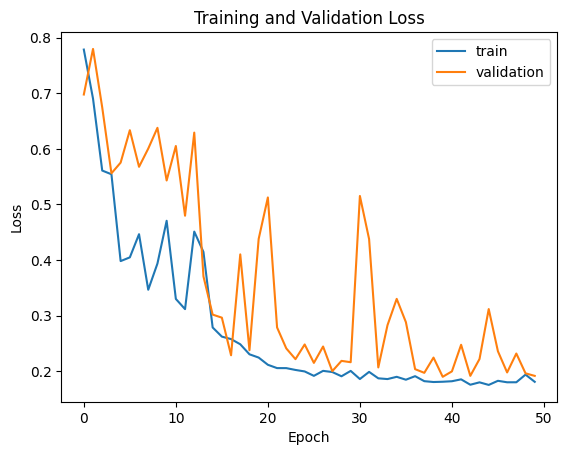

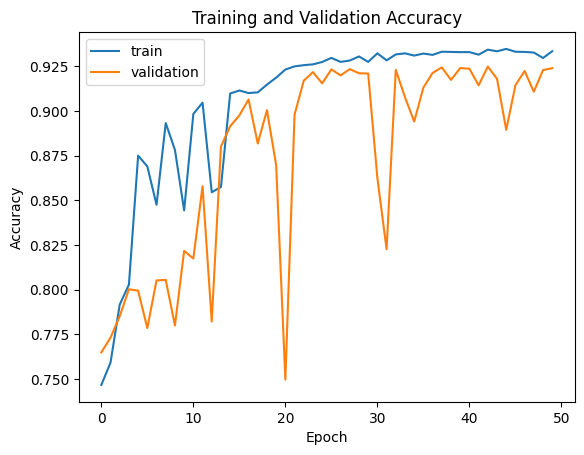

In [41]:
# Predict on test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
# Inverse transform the predictions and true labels
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

# Calculate and print accuracy, classification report, and confusion matrix
acc = accuracy_score(y_test_labels, y_pred_labels)
print(f'Accuracy: {acc}')

# Calculate loss score on test set
loss = model.evaluate(X_test, y_test, verbose=0)

# Print test loss score
print(f'Loss: {loss[0]}')

print(classification_report(y_test_labels, y_pred_labels))
print(confusion_matrix(y_test_labels, y_pred_labels))

# Plot training history
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()


# Plot accuracy from the loaded training history
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [42]:
# Print class names and their corresponding numerical values
class_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Class mapping:", class_mapping)


Class mapping: {'ERROR': 0, 'INFO': 1, 'WARNING': 2}


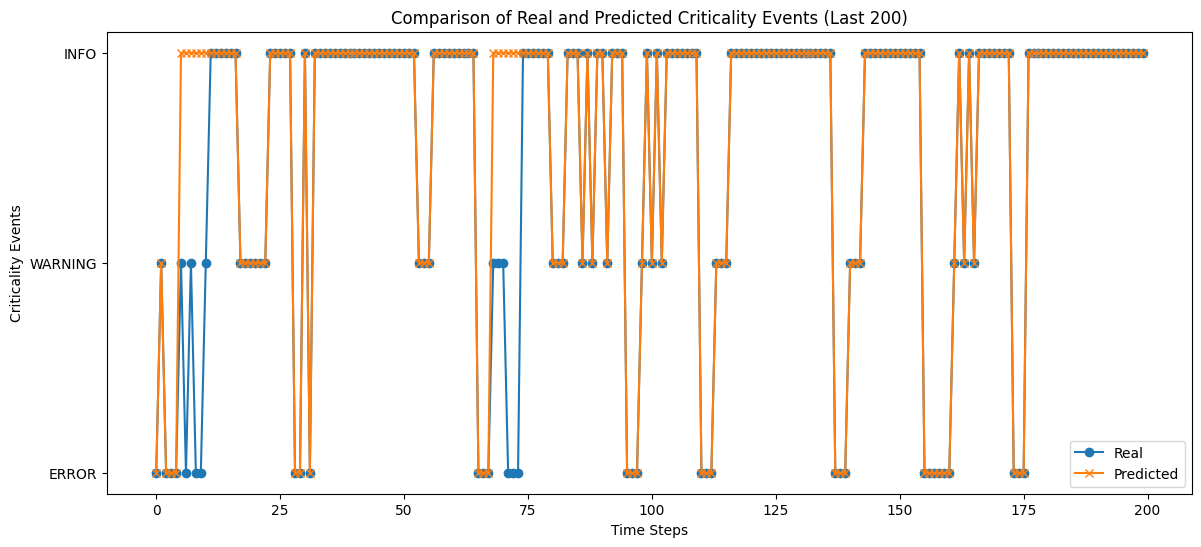

In [47]:
# Get the last 100 real and predicted values
y_test_last50 = y_test_labels[-200:]
y_pred_last50 = y_pred_labels[-200:]

# Create a line chart to visualize the real and predicted values
plt.figure(figsize=(14, 6))
plt.plot(y_test_last50, label='Real', marker='o')
plt.plot(y_pred_last50, label='Predicted', marker='x')
plt.xlabel('Time Steps')
plt.ylabel('Criticality Events')
plt.legend()
plt.title('Comparison of Real and Predicted Criticality Events (Last 200)')
plt.show()


In [ ]:
# # Define the start and end dates for the next week
# start_date = X_test_index.max() + datetime.timedelta(days=1)
# end_date = start_date + datetime.timedelta(weeks=1)

# # Generate a date range for the next week at 10-second intervals
# next_week_dates = pd.date_range(start=start_date, end=end_date, freq='10S')[:-1]


# # Create a new DataFrame with the index set as the 'created_at' column
# X_test_with_index = pd.DataFrame(X_test.reshape(X_test.shape[0], -1), columns=X.columns, index=X_test_index)

# # Merge the new DataFrame with the original data
# X_test_resampled = X_test_with_index.reset_index().merge(pd.DataFrame(index=next_week_dates), left_on='created_at', right_index=True, how='outer')

# # Forward fill the missing data
# X_test_resampled.fillna(method='ffill', inplace=True)

# # Drop the 'created_at' column
# X_test_resampled.drop(columns=['created_at'], inplace=True)

# # Resample y_test
# y_test_resampled = y_test.reset_index().merge(pd.DataFrame(index=next_week_dates), left_on='created_at', right_index=True, how='outer')
# y_test_resampled['created_at'] = pd.to_datetime(y_test_resampled['created_at'])  # Add this line
# y_test_resampled.fillna(method='ffill', inplace=True)
# y_test_resampled.drop(columns=['created_at'], inplace=True)

3162/3162 [==============================] - 13s 4ms/step


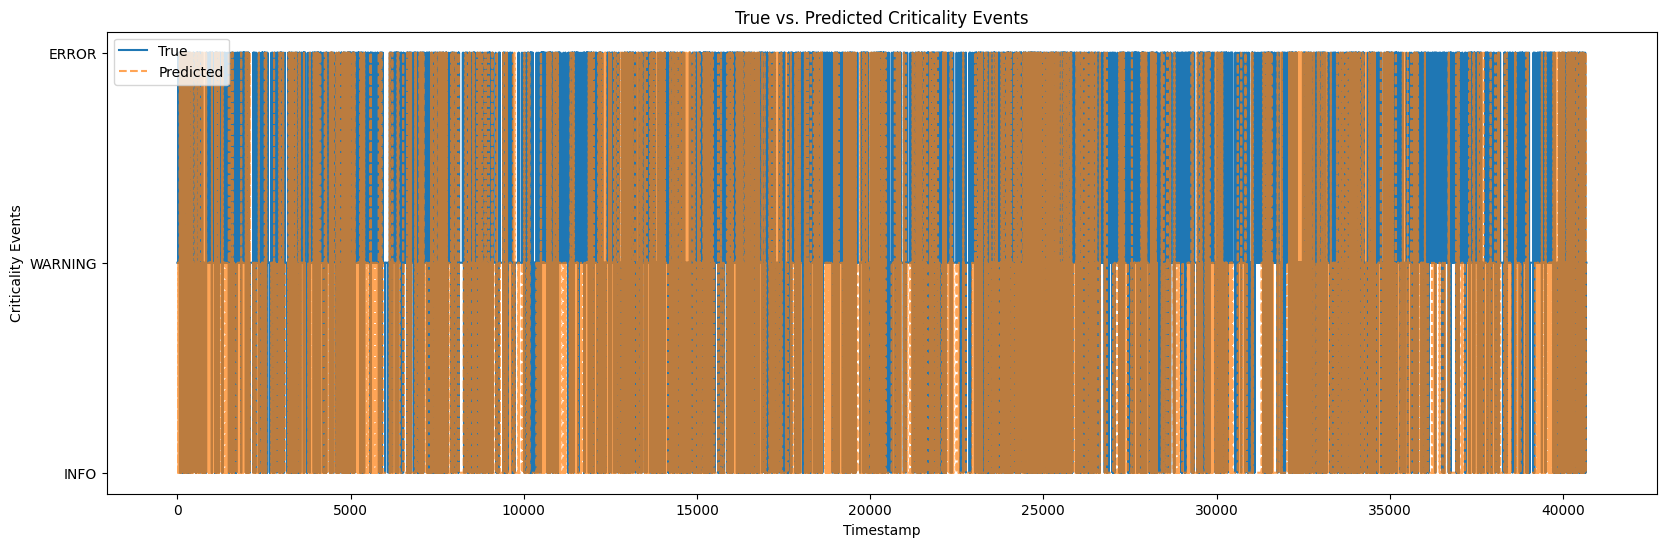

In [ ]:
# # Predict the 'criticality_events' for the resampled X_test data
# X_test_resampled_3D = X_test_resampled.values.reshape(X_test_resampled.shape[0], 1, X_test_resampled.shape[1])
# y_pred_resampled = model.predict(X_test_resampled_3D)

# # Convert the predicted probabilities to class labels
# y_pred_resampled_labels = np.argmax(y_pred_resampled, axis=1)
# y_pred_resampled_labels = le.inverse_transform(y_pred_resampled_labels)

# # Truncate or extend the index to match the length of the predicted values
# if len(next_week_dates) > len(y_pred_resampled_labels):
#     next_week_dates = next_week_dates[:len(y_pred_resampled_labels)]
# elif len(next_week_dates) < len(y_pred_resampled_labels):
#     next_week_dates = pd.date_range(start=start_date, periods=len(y_pred_resampled_labels), freq='10S')

# # Create a DataFrame with predicted labels and timestamps
# y_pred_resampled_df = pd.DataFrame(y_pred_resampled_labels, columns=['predicted_criticality'], index=next_week_dates)

# # Merge the true labels with the predicted labels
# comparison_df = y_test_resampled.reset_index().rename(columns={'index': 'created_at'})
# comparison_df['predicted_criticality'] = y_pred_resampled_labels
# comparison_df.set_index('created_at', inplace=True)

# # Rename the columns for better readability
# comparison_df.columns = ['true_criticality', 'predicted_criticality']

# plt.figure(figsize=(20, 6))
# plt.plot(comparison_df.index, comparison_df['true_criticality'], label='True')
# plt.plot(comparison_df.index, comparison_df['predicted_criticality'], label='Predicted', linestyle='--', alpha=0.7)
# plt.xlabel('Timestamp')
# plt.ylabel('Criticality Events')
# plt.title('True vs. Predicted Criticality Events')
# plt.legend()
# plt.show()